# Airbnb Data

This project looks at Airbnb Listing and Review data in Seattle 

Three questions:
1. What features relate to higher ratings
2. Which time of the year is good for business?
3. How to price appropriately? (predict price by time and features)

Data was scraped on 1/4/2016

Data of bookings (calendar.csv) ranged from 1/4/2016 to 1/2/2017

# Table of Content
1. [Import data](#heading1)
2. [Visualize](#heading2)
3. [Modeling](#heading3)
    1. [Question 1: How to get high ratings?](#heading3.1) - ([Conclusion](#conclusion1))
    2. [Question 2: How to be Superhost?](#heading3.2) - ([Conclusion](#conclusion2))
    3. [Question 3: Which months are good fo business?](#heading3.3) - ([Conclusion](#conclusion3))


# Import data<a name="heading1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

from IPython.display import display

#Metric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

#Decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

from sklearn.externals.six import StringIO
from IPython.display import Image
from graphviz import Source
import pydotplus

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# All information about the rentals and hosts
listings_df = pd.read_csv('./treated_data/listings_df.csv')
listings_df.drop(listings_df.columns[0], axis = 1, inplace = True)

# Contains all columns in listings_df, but categorical vars are made into dummy vars
listings_df_dummy = pd.read_csv('./treated_data/listings_df_dummy.csv')
listings_df_dummy.drop(listings_df_dummy.columns[0], axis = 1,inplace = True)

# similar to listings_df_dummy, just dont have host_response_time & host_response_rate
listings_df_price = pd.read_csv('./treated_data/listings_df_price.csv')
listings_df_price.drop(listings_df_price.columns[0], axis = 1,inplace = True)

# listings_df joined with calendar df
joined_calendar_listings = pd.read_csv('./treated_data/joined_calendar_listings.csv')
joined_calendar_listings.drop(joined_calendar_listings.columns[0], axis = 1,inplace = True)

# same as above, with dummy var
joined_calendar_listings_dummy = pd.read_csv('./treated_data/joined_calendar_listings_dummy.csv')
joined_calendar_listings_dummy.drop(joined_calendar_listings_dummy.columns[0], axis = 1,inplace = True)

In [3]:
# Function: Convert object to date
def to_date(df, col):
    '''
    Input: 
        df: dataframe
        col: column in string format (object) you want to convert into date
    Output:
        df: dataframe with updated column in date format. Every other columns are kept intact
    '''
    df[col] = pd.to_datetime(df[col])
    return df

In [4]:
# Convert date to datetime format
joined_calendar_listings = to_date(joined_calendar_listings, 'date')
joined_calendar_listings_dummy = to_date(joined_calendar_listings_dummy, 'date')

**Note on features of listings_df**

- host_response_time: 'within an hour' = 1,'within a few hours' = 2 ,'within a day' = 3 , 'a few days or more = 4

- cancellation_policy: 'flexible' =1, 'moderate'= 2,'strict'= 3
  
- neighborhood_type: 'High price' = mean price >$100, 'Low price' = mean price <$100

- property_type: house, apartment, other


In [5]:
listings_df.head()

,id,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,neighborhood,property_type,room_type,accommodates,bathrooms,...,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,cancellation_policy,reviews_per_month,days_hosted,neighborhood_type
0,241032,2.0,96.0,f,3.0,Queen Anne,Apartment,Entire home/apt,4,1.0,...,14,41,71,346,207,95.0,2,4.07,1607.0,high price
1,953595,1.0,98.0,t,6.0,Queen Anne,Apartment,Entire home/apt,4,1.0,...,13,13,16,291,43,96.0,3,1.48,1047.0,high price
2,3308979,2.0,67.0,f,2.0,Queen Anne,House,Entire home/apt,11,4.5,...,1,6,17,220,20,97.0,3,1.15,571.0,high price
3,278830,1.0,100.0,f,2.0,Queen Anne,House,Entire home/apt,6,2.0,...,30,60,90,365,38,92.0,3,0.89,1497.0,high price
4,1909058,1.0,100.0,t,1.0,Queen Anne,House,Private room,2,1.0,...,20,49,71,346,58,99.0,2,2.46,1314.0,high price


In [6]:
# Contains all columns in listings_df, but categorical vars are made into dummy vars
listings_df_dummy.head()

,host_response_time,host_response_rate,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,...,bed_type_Other,bed_type_Real Bed,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t
0,2.0,96.0,3.0,4,1.0,1.0,1.0,85.0,2,5.0,...,0,1,1,0,0,1,0,0,1,0
1,1.0,98.0,6.0,4,1.0,1.0,1.0,150.0,1,0.0,...,0,1,1,0,0,1,0,0,0,1
2,2.0,67.0,2.0,11,4.5,5.0,7.0,975.0,10,25.0,...,0,1,0,1,0,1,0,0,1,0
3,1.0,100.0,2.0,6,2.0,3.0,3.0,450.0,6,15.0,...,0,1,0,1,0,1,0,0,1,0
4,1.0,100.0,1.0,2,1.0,1.0,1.0,80.0,1,10.0,...,0,1,0,1,0,0,1,0,0,1


In [7]:
#similar to listings_df_dummy, just dont have host_response_time & host_response_rate
listings_df_price.head()

,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,availability_30,availability_60,...,bed_type_Other,bed_type_Real Bed,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t
0,3.0,4,1.0,1.0,1.0,85.0,2,5.0,14,41,...,0,1,1,0,0,1,0,0,1,0
1,6.0,4,1.0,1.0,1.0,150.0,1,0.0,13,13,...,0,1,1,0,0,1,0,0,0,1
2,2.0,11,4.5,5.0,7.0,975.0,10,25.0,1,6,...,0,1,0,1,0,1,0,0,1,0
3,1.0,3,1.0,0.0,2.0,100.0,1,0.0,0,0,...,0,1,1,0,0,1,0,0,1,0
4,2.0,6,2.0,3.0,3.0,450.0,6,15.0,30,60,...,0,1,0,1,0,1,0,0,1,0


In [8]:
# listings_df_price joined with calendar df
joined_calendar_listings.head()

,listing_id,date,available,price_calendar,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,neighborhood,property_type,...,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,cancellation_policy,reviews_per_month,days_hosted,neighborhood_type
0,241032,2016-01-04,t,85.0,2.0,96.0,f,3.0,Queen Anne,Apartment,...,14,41,71,346,207,95.0,2,4.07,1607.0,high price
1,241032,2016-01-05,t,85.0,2.0,96.0,f,3.0,Queen Anne,Apartment,...,14,41,71,346,207,95.0,2,4.07,1607.0,high price
2,241032,2016-01-13,t,85.0,2.0,96.0,f,3.0,Queen Anne,Apartment,...,14,41,71,346,207,95.0,2,4.07,1607.0,high price
3,241032,2016-01-14,t,85.0,2.0,96.0,f,3.0,Queen Anne,Apartment,...,14,41,71,346,207,95.0,2,4.07,1607.0,high price
4,241032,2016-01-18,t,85.0,2.0,96.0,f,3.0,Queen Anne,Apartment,...,14,41,71,346,207,95.0,2,4.07,1607.0,high price


# Analyze & Visualize<a name="heading2"></a>

### Continuous Variable

In [9]:
listings_df.describe()

,id,host_response_time,host_response_rate,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,cancellation_policy,reviews_per_month,days_hosted
count,3.275000e+03,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000
mean,5.513713e+06,1.688244,94.899237,8.034809,3.387786,1.259695,1.299542,1.752061,124.648855,1.698931,10.950534,17.611298,38.727023,61.067786,250.273893,24.522443,82.017405,2.120916,1.939548,848.601221
std,2.961650e+06,0.802161,11.850200,30.634215,1.997212,0.593021,0.871238,1.149310,87.979711,1.328825,17.204721,11.648672,22.024255,31.875564,124.401518,39.404444,32.632176,0.808499,1.879382,565.799806
min,3.335000e+03,1.000000,17.000000,1.000000,1.000000,0.000000,0.000000,1.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.000000
25%,3.209798e+06,1.000000,98.000000,1.000000,2.000000,1.000000,1.000000,1.000000,72.000000,1.000000,0.000000,5.000000,22.000000,38.000000,137.000000,2.000000,90.000000,1.000000,0.480000,383.500000
50%,6.066185e+06,1.000000,100.000000,1.000000,3.000000,1.000000,1.000000,1.000000,100.000000,1.000000,0.000000,21.000000,48.000000,75.000000,316.000000,11.000000,95.000000,2.000000,1.380000,774.000000
75%,8.031308e+06,2.000000,100.000000,3.000000,4.000000,1.000000,2.000000,2.000000,150.000000,2.000000,20.000000,30.000000,59.000000,89.000000,359.000000,29.000000,98.000000,3.000000,2.930000,1254.500000
max,1.034016e+07,4.000000,100.000000,502.000000,16.000000,8.000000,7.000000,15.000000,999.000000,15.000000,300.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,3.000000,12.150000,2611.000000


All variables are not normally distributed, which we must pay attention to when modelling. Regression might not be a good choice to model data as is. Maybe we can benefit from log-transformed regression.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e64f240>,
      dtype=object)

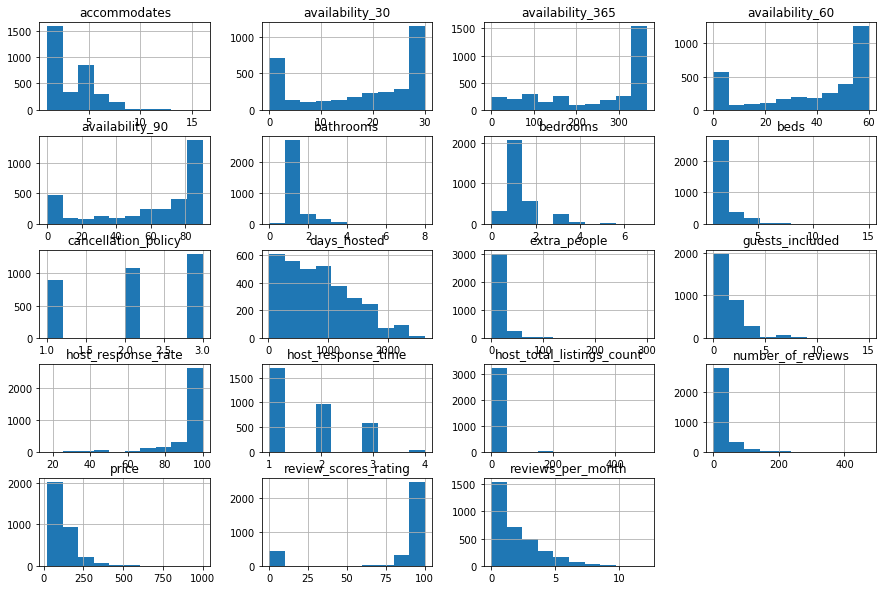

In [10]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
listings_df.drop(columns = 'id', axis = 1).hist(ax = ax)

Log-transformed price resembles a normal curve. We should use log-transformed Price in regression model instead of just Price

Other variables that give us more information when log-transformed are: 
- days_hosted
- number_of_reviews
- reviews_per_month

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1225dbbe0>,
      dtype=object)

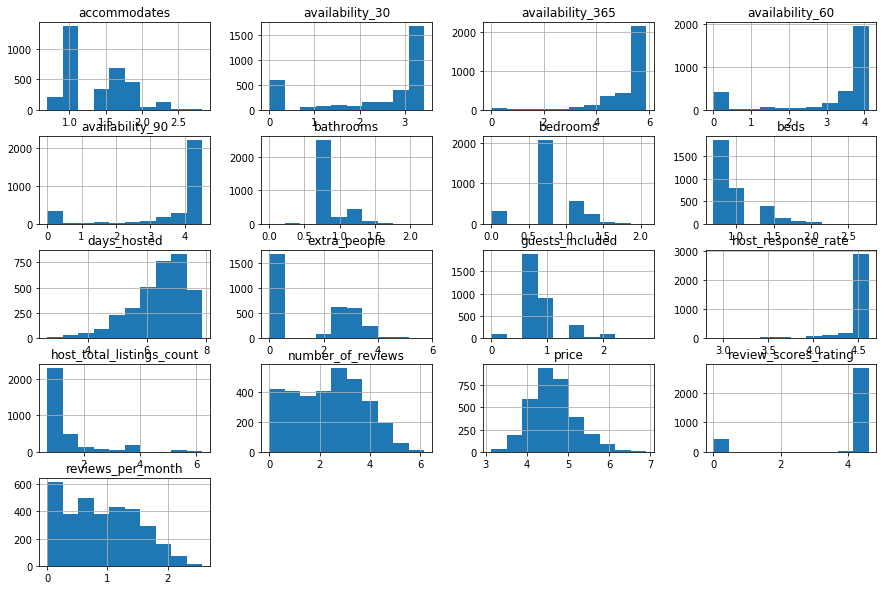

In [11]:
to_log_df = listings_df[['accommodates','availability_30', 'availability_365', 'availability_60', 'availability_90',\
                    'bathrooms', 'bedrooms','beds','days_hosted', 'extra_people','guests_included',\
                    'host_response_rate','host_total_listings_count','number_of_reviews','price',\
                    'review_scores_rating','reviews_per_month']]
log_df = np.log(to_log_df+1)

fig = plt.figure(figsize=(15,10))
ax = fig.gca()
log_df.hist(ax = ax)


#### Correlational Matrix: 

Observations: 
- Hosts take longer time to respond have fewer reviews per month, and have lightly lower score

- Price is positively correlated with number of features (number of people a rental can accommodate, number of beds, bathrooms, and bedrooms). This makes sense but does not help us to learn anything new. However, correlational only reflect linear relationship. Some non-linear relationship might still be hidden.

- Review score has a relatively strong positive relationship with number of reviews per month. Is that people who host more provide generally better services? Or most review are rated high (10 or close to 10), so more reviews means higher score? 

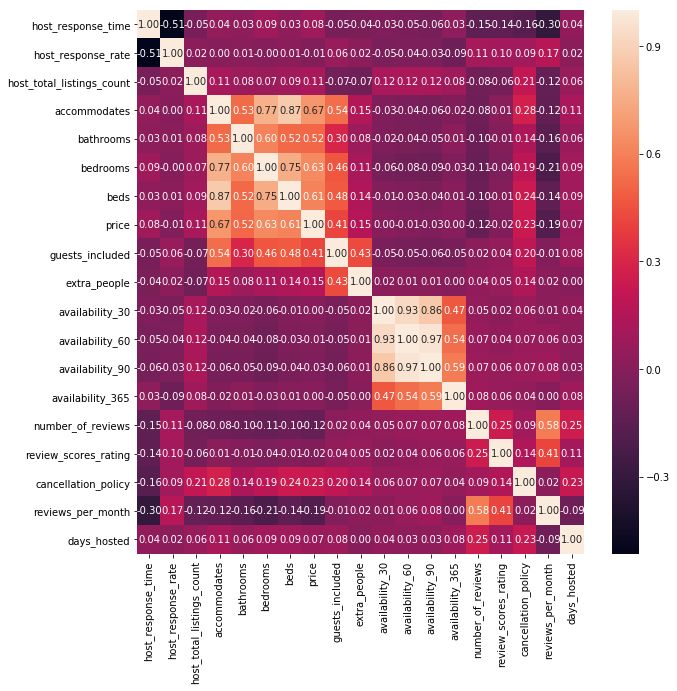

In [12]:
plt.figure(figsize = (10,10))
sns.heatmap(listings_df.drop(columns = 'id', axis = 1).corr(), annot=True, fmt=".2f")

### Categorical Variables

Text(0.5, 1.0, 'host_is_superhost')

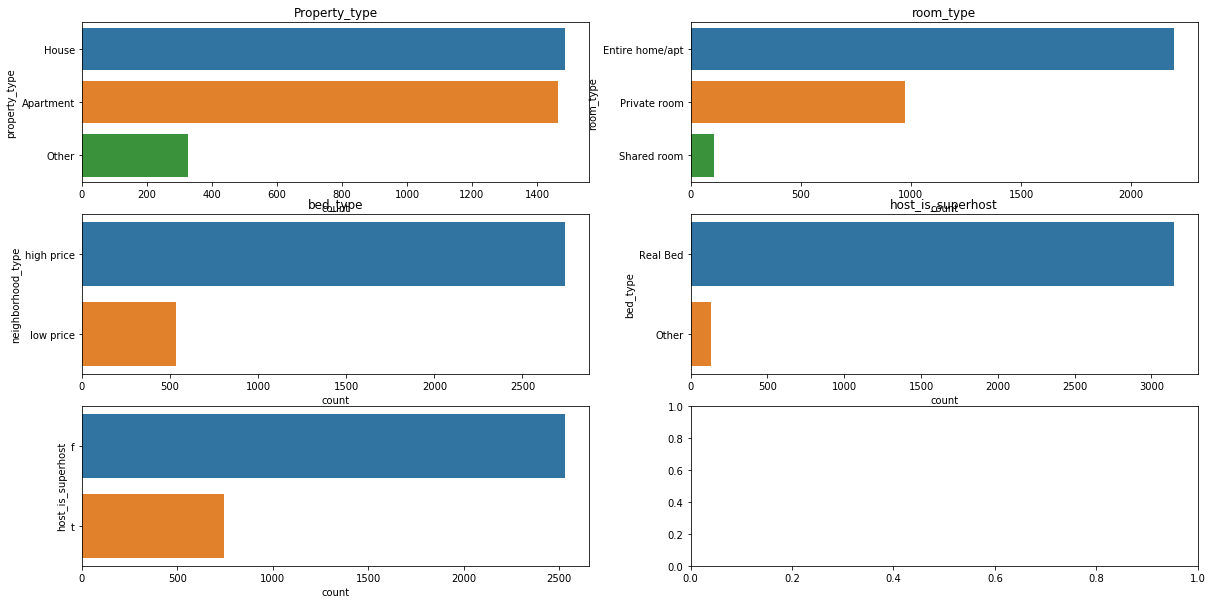

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(20,10))

sns.countplot(y='property_type', data =  listings_df,\
              order=listings_df['property_type'].value_counts().index, ax = axs[0][0])
axs[0, 0].set_title('Property_type')

sns.countplot(y='room_type', data =  listings_df,\
              order=listings_df['room_type'].value_counts().index, ax = axs[0][1])
axs[0, 1].set_title('room_type')

sns.countplot(y='neighborhood_type', data =  listings_df,\
              order=listings_df['neighborhood_type'].value_counts().index, ax = axs[1][0])
axs[1, 0].set_title('neighborhood_type')

sns.countplot(y='bed_type', data =  listings_df,\
              order=listings_df['bed_type'].value_counts().index, ax = axs[1][1])
axs[1, 0].set_title('bed_type')

sns.countplot(y='host_is_superhost', data =  listings_df,\
              order=listings_df['host_is_superhost'].value_counts().index, ax = axs[2][0])
axs[1, 1].set_title('host_is_superhost')


### Multivariate analysis - Price 

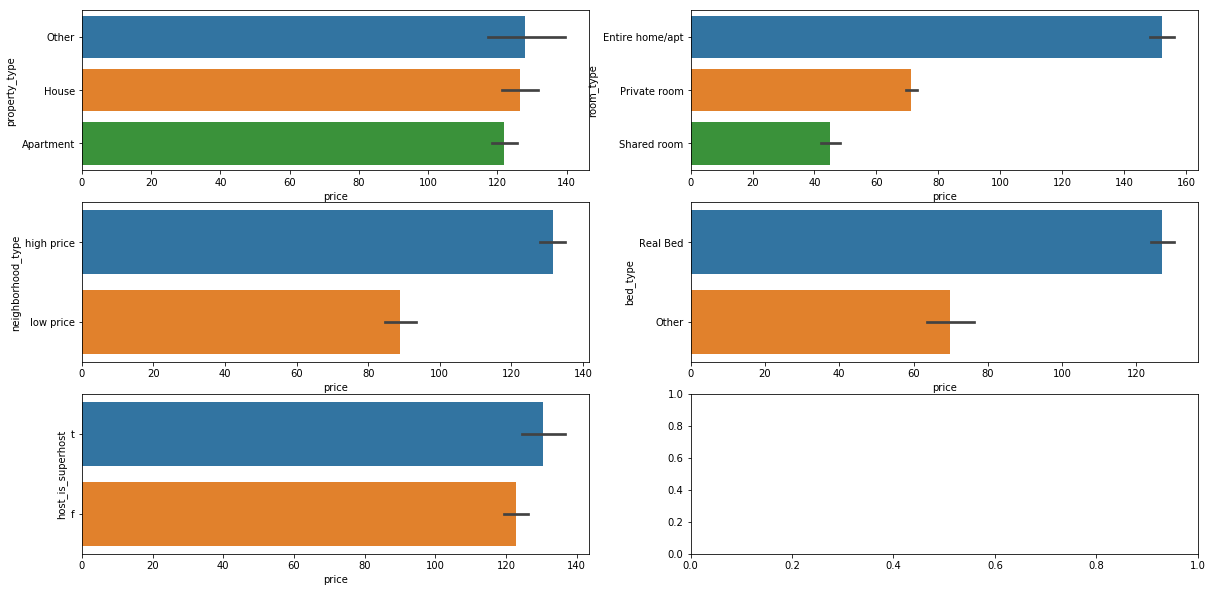

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(20,10))

sns.barplot(y = 'property_type', x = 'price', data =  listings_df, \
            order=listings_df.groupby('property_type')['price'].mean().sort_values(ascending=False).index,\
            ax = axs[0,0])


sns.barplot(y = 'room_type', x = 'price', data =  listings_df, ax = axs[0,1])


sns.barplot(y = 'neighborhood_type', x = 'price', data =  listings_df, 
            order=listings_df.groupby('neighborhood_type')['price'].mean().sort_values(ascending=False).index,\
            ax = axs[1,0])


sns.barplot(y = 'bed_type', x = 'price', data =  listings_df, 
            order=listings_df.groupby('bed_type')['price'].mean().sort_values(ascending=False).index,\
            ax = axs[1,1])


sns.barplot(y = 'host_is_superhost', x = 'price', data =  listings_df,\
            order=listings_df.groupby('host_is_superhost')['price'].mean().sort_values(ascending=False).index,\
            ax = axs[2,0])


### Multivariate analysis - Time & Price 

Observation about temporal pattern of price:

- Apartment price rises in summer months (possibly group Jun, Jul, Aug into a group, or group by quarter?)
- Entire house/apartment price also rises slightly in summer months
- High priced neighborhood seems to have higher price flutuation throughout the year

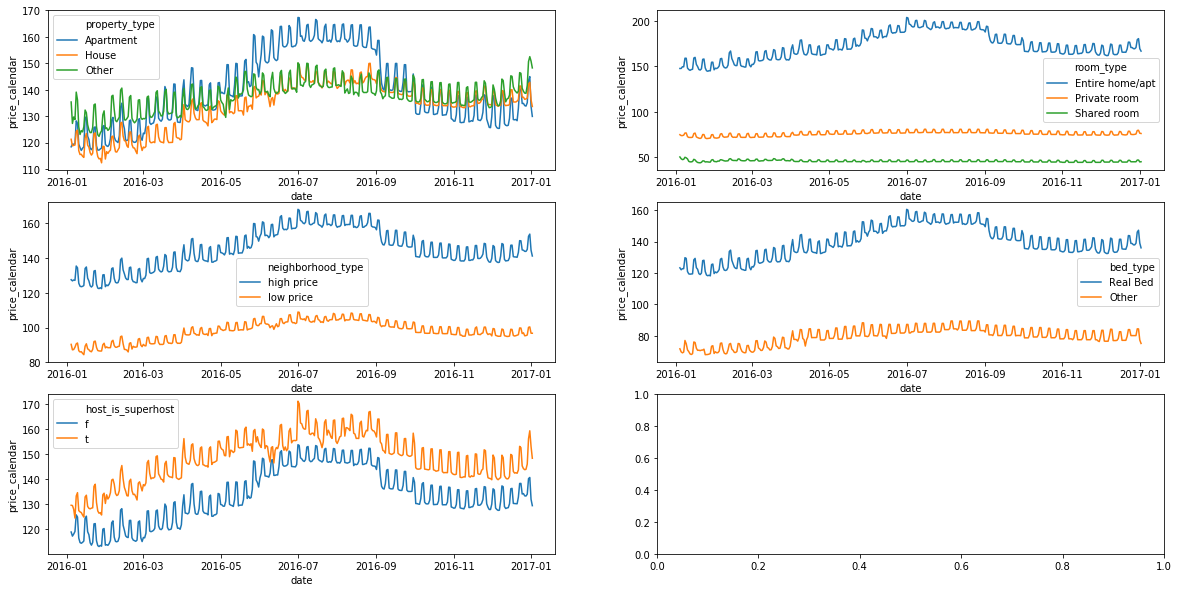

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(20,10))

sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'property_type', ci = None, ax = axs[0,0])
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'room_type', ci = None, ax = axs[0,1])
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'neighborhood_type', ci = None, ax = axs[1,0])
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'bed_type', ci = None, ax = axs[1,1])
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'host_is_superhost', ci = None, ax = axs[2,0])

In [16]:
temp = joined_calendar_listings[['date','price_y', 'price_calendar']]
temp['% change'] = (temp['price_calendar'] - temp['price_y'])/temp['price_y']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
temp.describe()

,price_y,price_calendar,% change
count,819647.000000,819647.000000,819647.000000
mean,124.796794,136.611162,0.092421
std,88.134366,104.864489,0.304752
min,22.000000,10.000000,-0.940828
25%,70.000000,75.000000,0.000000
50%,100.000000,105.000000,0.000000
75%,150.000000,160.000000,0.000000
max,975.000000,1650.000000,7.378378


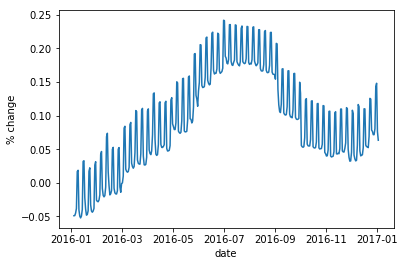

In [18]:
sns.lineplot(data = temp, x = 'date', y = '% change', \
 ci = None)

# Modeling<a name="heading3"></a>

In [19]:
# Metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true-y_pred)/y_true)) *100
    return mape

In [20]:
# Visualize decision tree
def visualize(model,df):
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, max_depth=5,feature_names=df.columns,
    filled=True, rounded=True,special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

In [21]:
from sklearn.model_selection import cross_val_score, GridSearchCV

def grid_search_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=DecisionTreeRegressor(),
        param_grid={
            'max_depth': range(3, 15),
            'min_samples_leaf': (50, 60, 70, 80, 90, 100, 120, 150),
        },
        cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = DecisionTreeRegressor(max_depth=best_params["max_depth"],\
                                min_samples_leaf=best_params["min_samples_leaf"],\
                                random_state=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')
    best = {'max_depth': best_params["max_depth"], 
           'min_samples_leaf':best_params["min_samples_leaf"]}
    return best

## Question 1: What features relate to higher rating?<a name="heading3.1"></a>

We will try with both response and without response data


### Model 1: Use dataframe with no host's response behavior data

In [22]:
listings_df_price.columns

Index(['host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'guests_included', 'extra_people', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'cancellation_policy',
       'reviews_per_month', 'days_hosted', 'neighborhood_type_high price',
       'neighborhood_type_low price', 'bed_type_Other', 'bed_type_Real Bed',
       'property_type_Apartment', 'property_type_House', 'property_type_Other',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'host_is_superhost_f', 'host_is_superhost_t'],
      dtype='object')

In [23]:
def decision_tree_model(df, y_col_name):
    '''
    INPUT:
    - df: dataframe
    - y_col_name: dependent variable column name, in string format
    
    OUTPUT:
    - MAE, MSE, MAPE
    - Visualization of decision tree
    '''
    # Make X, y
    y = df[[y_col_name]]
    X = df.drop(columns = [y_col_name])
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 22)
    
    #Grid seach
    grid_search_parameters = grid_search_model(X_train, y_train)
    print('hyper parameter: ', grid_search_parameters)
    
    # Initiate model 
    model = DecisionTreeRegressor(min_samples_leaf = grid_search_parameters.get('min_samples_leaf'), 
                                 max_depth = grid_search_parameters.get('max_depth'))
    model.fit(X_train, y_train)

    
    #validate in-sample
    y_pred = model.predict(X_train)
    print('in-sample metrics:')
    print('MAE in-sample: {}'.format(mean_absolute_error(y_train, y_pred)))
    print('MSE in-sample: {}'.format(mean_squared_error(y_train, y_pred)))
    print('MAPE in-sample: {}'.format(mean_absolute_percentage_error(y_train, y_pred)))

    
    #validate out-sample
    y_pred = model.predict(X_test)
    print('out-sample metrics:')
    print('MAE out-sample: {}'.format(mean_absolute_error(y_test, y_pred)))
    print('MSE out-sample: {}'.format(mean_squared_error(y_test, y_pred)))
    print('MAPE out-sample: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    #Feature importance
    feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    print("Percentage of importance for each feature in the model:")
    print(feature_importances)
    # Visualize
    return visualize(model, X_train)


hyper parameter:  {'max_depth': 4, 'min_samples_leaf': 50}
in-sample metrics:
MAE in-sample: 4.074651831659602
MSE in-sample: 73.972691190991
MAPE in-sample: nan
out-sample metrics:
MAE out-sample: 4.148642297369118
MSE out-sample: 84.44423096762809
MAPE out-sample: nan
Percentage of importance for each feature in the model:
                              importance
reviews_per_month               0.993383
number_of_reviews               0.003030
host_is_superhost_t             0.001730
bathrooms                       0.001248
host_total_listings_count       0.000608
neighborhood_type_high price    0.000000
host_is_superhost_f             0.000000
room_type_Shared room           0.000000
room_type_Private room          0.000000
room_type_Entire home/apt       0.000000
property_type_Other             0.000000
property_type_House             0.000000
property_type_Apartment         0.000000
bed_type_Real Bed               0.000000
bed_type_Other                  0.000000
neighborhood_type

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


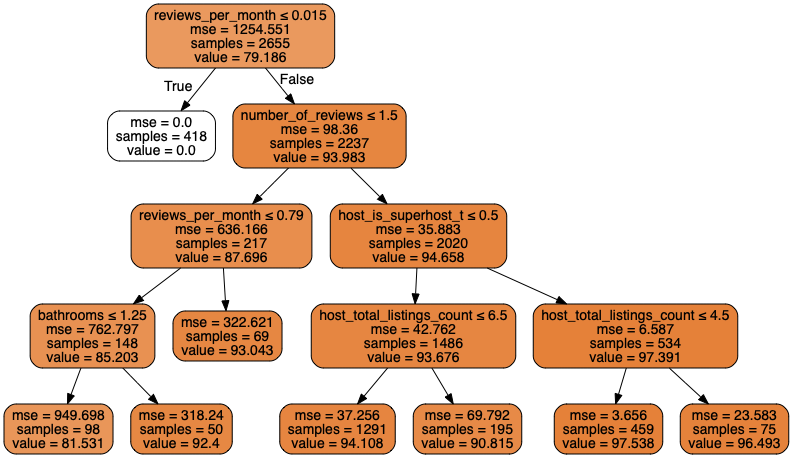

In [24]:
model_1_df = listings_df_price.copy()
decision_tree_model(model_1_df, 'review_scores_rating')

Reviews per months is 99.4% importance in predicting. However, it seems to be most important in distinguishing listings that do not have any review --> 0 rating. Therefore, I opt to remove 302 listings that has review rating = 0

Because ratings is tied heavily with superhost status (based on Airbnb website, to be superhost, you have to have more than 80% 5 star ratings. Also, number of reviews is highly correlated with ratings (maybe attractive ratings attracts more people and have higher ratings, but it does not help new host). I want to remove this variable to get more meaningful result for new host

### Model 2: Still without host's response behavior data, but drop number of reviews received

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


hyper parameter:  {'max_depth': 3, 'min_samples_leaf': 60}
in-sample metrics:
MAE in-sample: 4.459584772857739
MSE in-sample: 44.674722217472926
MAPE in-sample: 5.702712208819906
out-sample metrics:
MAE out-sample: 4.162782475775547
MSE out-sample: 33.99123319389332
MAPE out-sample: 4.798880287274631
Percentage of importance for each feature in the model:
                              importance
availability_365                0.394315
host_total_listings_count       0.363793
extra_people                    0.090649
price                           0.084491
availability_30                 0.066751
neighborhood_type_high price    0.000000
room_type_Private room          0.000000
room_type_Entire home/apt       0.000000
property_type_Other             0.000000
property_type_House             0.000000
property_type_Apartment         0.000000
bed_type_Real Bed               0.000000
bed_type_Other                  0.000000
neighborhood_type_low price     0.000000
cancellation_policy        

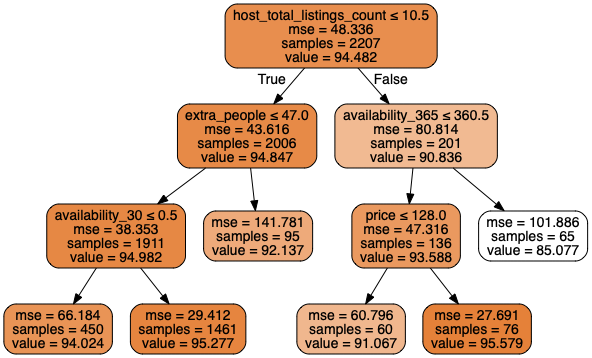

In [25]:
model_2_df = listings_df_price[listings_df_price.review_scores_rating != 0] # Remove ratings = 0
model_2_df.drop(columns = ['host_is_superhost_t', 'host_is_superhost_f',\
                                        'number_of_reviews', 'reviews_per_month'], axis = 1, inplace = True)

decision_tree_model(model_2_df, 'review_scores_rating')

This model is effective because out-sample metrics are better than in-sample metrics, indicating that we did not overfitted the model with training data. 

I will retry this approach with host's response style (host response rate and host response speed) to understand how host's behavior affect their listing's ratings

### Model 3: Similar to model 2, but with host's response data

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


hyper parameter:  {'max_depth': 4, 'min_samples_leaf': 70}
in-sample metrics:
MAE in-sample: 4.123726253330472
MSE in-sample: 37.444047588976794
MAPE in-sample: 5.35804823090633
out-sample metrics:
MAE out-sample: 4.407700902376119
MSE out-sample: 44.13914316463648
MAPE out-sample: 5.373040789803902
Percentage of importance for each feature in the model:
                              importance
host_total_listings_count       0.423145
price                           0.211884
days_hosted                     0.114900
host_response_rate              0.112593
availability_60                 0.086862
property_type_Apartment         0.050616
host_response_time              0.000000
room_type_Private room          0.000000
room_type_Entire home/apt       0.000000
property_type_Other             0.000000
property_type_House             0.000000
bed_type_Real Bed               0.000000
bed_type_Other                  0.000000
neighborhood_type_low price     0.000000
neighborhood_type_high price

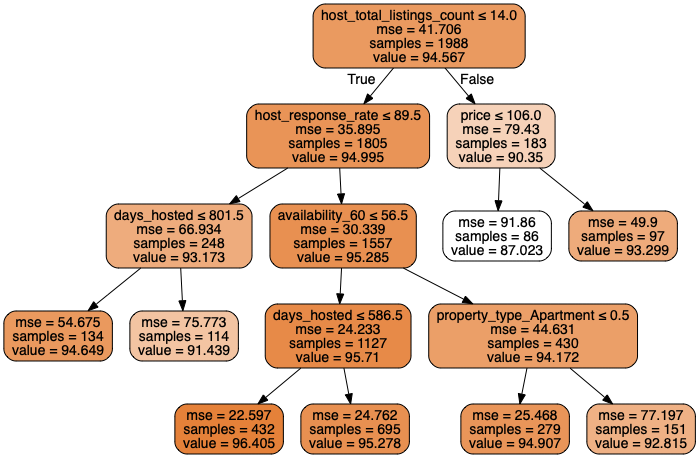

In [26]:
model_3_df = listings_df_dummy[listings_df_dummy.review_scores_rating != 0] # Remove ratings = 0
model_3_df.drop(columns = ['host_is_superhost_t', 'host_is_superhost_f',\
                                        'number_of_reviews', 'reviews_per_month'], axis = 1, inplace = True)

decision_tree_model(model_3_df, 'review_scores_rating')

### Question 1 - Conclusion<a name="conclusion1"></a>

Model 3 provided some interesting insights on features of listings and host behaviors

- Interestingly, the number of listings of a host is the most important feature to ratings score (42.3%). This decision tree indicates that hosts that have fewer listings received higher ratings on Airbnb. This might due to hosts with fewer listings and provide better customer service and care to their property.
- However, hosts that own >14 listings can still have a chance to earn high ratings if their price is higher than `$106`. The worst performing group we observe here is hosts that own more than 14 listings and their rental are priced lower than `$106`. Maybe owning multiple affordable property for rent on Airbnb is not a good strategy.
- When hosts have fewer than 14 listings, a less choosy request responder might recieve higher rating than a host that respond to request less frequently. The more responsive the host is, the higher satisfaction of renters are. - If a property is heavily booked in the next 60 days, the ratings is slightly lower. Can it be due to sanitary problem, or check-in, check-out problem?

# Question 3: What to do to be a superhost?<a name="heading3.2"></a>

This is a classification problem. I use decision tree model to have a peek at the difference between superhost and non-superhost

In [27]:
from sklearn.model_selection import cross_val_score, GridSearchCV

def grid_search_model_classifier(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={
            'max_depth': range(3, 15),
            'min_samples_leaf': (50, 60, 70, 80, 90, 100, 120, 150),
        },
        cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = DecisionTreeRegressor(max_depth=best_params["max_depth"],\
                                min_samples_leaf=best_params["min_samples_leaf"],\
                                random_state=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')
    best = {'max_depth': best_params["max_depth"], 
           'min_samples_leaf':best_params["min_samples_leaf"]}
    return best

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

model_q3_1_df = listings_df_dummy.dropna(how = 'any', axis = 0)
model_q3_1_df.drop(columns = 'host_is_superhost_f', axis = 1, inplace = True )

X = model_q3_1_df.drop(columns = 'host_is_superhost_t', axis = 1)
y  =model_q3_1_df[['host_is_superhost_t']]

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Hyper parameter via grid search
parameter = grid_search_model_classifier(X_train, y_train)

# Model
clf = DecisionTreeClassifier(max_depth= parameter.get('max_depth'),\
                             min_samples_leaf = parameter.get('min_samples_leaf'))
clf = clf.fit(X_train,y_train)


# Metrics for in-sample
#Predict the response for test dataset
y_pred_train = clf.predict(X_train)
print('In-sample Metrics: ')
print("In-sample Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
print("In-sample Precision:",metrics.precision_score(y_train, y_pred_train))
print("In-sample F-score:",metrics.f1_score(y_train, y_pred_train))

# Metrics for out-sample 
#Predict the response for test dataset
y_pred = clf.predict(X_test)
print('Out-sample Metrics: ')
print("Out-sample Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Out-sample Precision:",metrics.precision_score(y_test, y_pred))
print("Out-sample F-score:",metrics.f1_score(y_test, y_pred))

In-sample Metrics: 
In-sample Accuracy: 0.8520942408376964
In-sample Precision: 0.706855791962175
In-sample F-score: 0.6382070437566703
Out-sample Metrics: 
Out-sample Accuracy: 0.844354018311292
Out-sample Precision: 0.7119565217391305
Out-sample F-score: 0.6313253012048193


In [29]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Not Superhost', 'Predicted Superhost'],
    index=['True Not Superhost', 'True Superhost']
)

,Predicted Not Superhost,Predicted Superhost
True Not Superhost,699,53
True Superhost,100,131


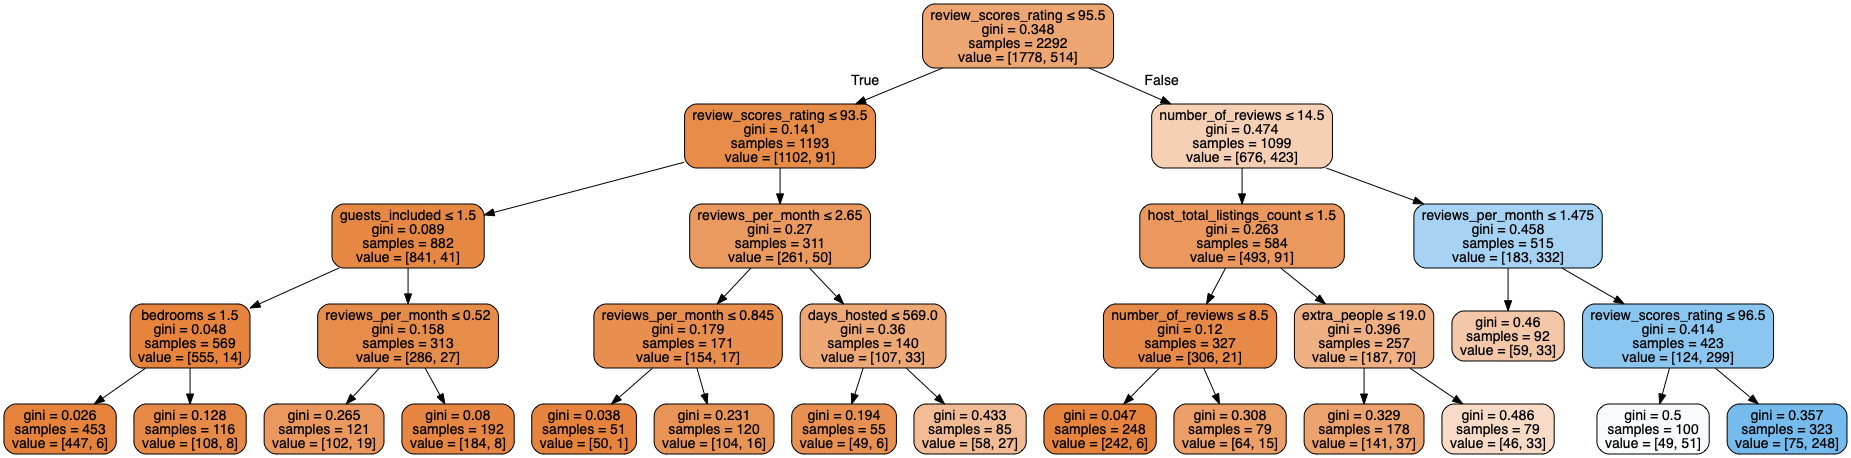

In [30]:
visualize(clf, X_train)

In [31]:
#Feature importance
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print("Percentage of importance for each feature in the model:")
print(feature_importances)

Percentage of importance for each feature in the model:
                              importance
number_of_reviews               0.438766
review_scores_rating            0.409449
reviews_per_month               0.078801
host_total_listings_count       0.040806
extra_people                    0.015771
days_hosted                     0.009506
guests_included                 0.005024
bedrooms                        0.001877
property_type_Other             0.000000
property_type_House             0.000000
room_type_Entire home/apt       0.000000
property_type_Apartment         0.000000
bed_type_Real Bed               0.000000
bed_type_Other                  0.000000
neighborhood_type_low price     0.000000
neighborhood_type_high price    0.000000
room_type_Private room          0.000000
host_response_time              0.000000
cancellation_policy             0.000000
host_response_rate              0.000000
availability_365                0.000000
availability_90                 0.000000
a

### Question 2 - Conclusion <a name="conclusion2"></a>

Top 3 features that were important in the decision tree model were number_of_reviews, review_scores_rating, and reviews_per_month. This is consistent with the superhost status criteria. 

So, in order to be superhost, one must 

# Question 3: Where my resources should go in different months of a year?<a name="heading3.3"></a>

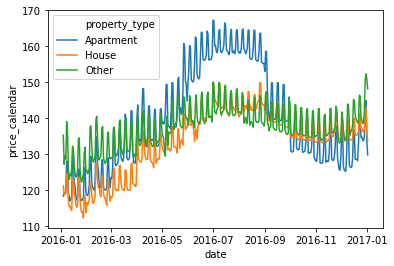

In [32]:
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'property_type', ci = None)

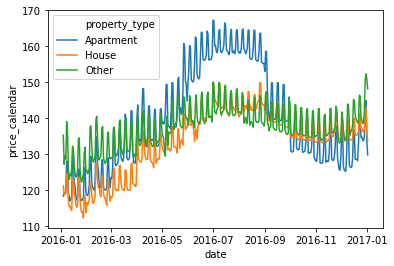

In [33]:
sns.lineplot(data = joined_calendar_listings, x = 'date', y = 'price_calendar', \
             hue = 'property_type', ci = None)

In [34]:
temp = joined_calendar_listings[['date','price_y', 'price_calendar', 'property_type']]
temp['% change'] = (temp['price_calendar'] - temp['price_y'])/temp['price_y']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
temp.describe()

,price_y,price_calendar,% change
count,819647.000000,819647.000000,819647.000000
mean,124.796794,136.611162,0.092421
std,88.134366,104.864489,0.304752
min,22.000000,10.000000,-0.940828
25%,70.000000,75.000000,0.000000
50%,100.000000,105.000000,0.000000
75%,150.000000,160.000000,0.000000
max,975.000000,1650.000000,7.378378


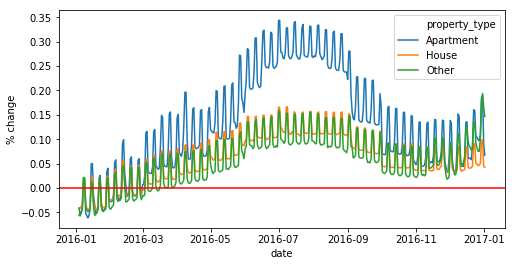

In [36]:
# fig, axs = plt.subplots(3, 2, figsize=(20,10))
fig = plt.figure(figsize=(8,4))
sns.lineplot(data = temp, x = 'date', y = '% change', hue = 'property_type', \
 ci = None)
plt.axhline(0, color = 'r')

In [37]:
reviews = pd.read_csv('./seattle/reviews.csv')
reviews = to_date(reviews, 'date')
reviews['month'] = pd.DatetimeIndex(reviews['date']).month

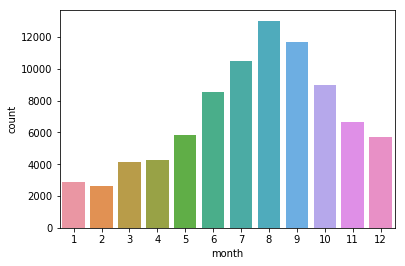

In [38]:
sns.countplot(data = reviews, x = 'month')

In [39]:
listings = pd.read_csv('./seattle/listings.csv')

In [40]:
reviews_time_df = to_date(reviews_time_df, 'date_x')
reviews_time_df['month_x'] = pd.DatetimeIndex(reviews_time_df['date_x']).month

NameError: name 'reviews_time_df' is not defined

In [ ]:
reviews_time_df = reviews.merge(listings_df, left_on = 'listing_id', right_on = 'id', how = 'left')

In [ ]:
sns.countplot(data = reviews_time_df, x = 'month_x', hue = 'property_type')

In [ ]:
reviews.head()

In [ ]:
temp2 = reviews_time_df[['month_x', 'property_type', 'id']]

In [ ]:
count_table = temp2.groupby(['month_x', 'property_type']).count()

In [ ]:
count_table.groupby(['property_type']).mean().reset_index()

In [ ]:
temp2_with_mean = temp2.merge(count_table, how = 'left', on ='property_type')

In [ ]:
temp2_with_mean.rename(columns={'month_x':'month', 'id_y':'review_id', 'id_x':'mean_reviews_count'}, inplace = True)

In [ ]:
sns.countplot(data = temp2_with_mean, x = 'month', hue = 'property_type')

In [ ]:
temp2_with_mean.shape

In [ ]:
reviews.shape

### Question 3 - Conclusion <a name="conclusion3"></a>